In [71]:
%reset

In [72]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [73]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNLE, SNPE#, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
from joblib import Parallel, delayed, parallel_backend
from scipy.integrate import quad, simpson
import pickle
from scipy.stats import norm
import sources.DMsignal as DMsignal
import sources.FermiBackgrounds as FermiBackgrounds
from astropy import units as u


%matplotlib inline

In [74]:
grains=1000
num_simulations = 480
num_workers = 48

In [75]:
parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1_000, 100_000] #MeV 
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
# max_radius = 8.5 + 20*2 #kpc
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2_000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut_degrees = 180 #degrees # 180 degress is full sky
angular_cut = angular_cut_degrees*u.deg.to('rad') # radians
angular_cut_gen =  min(angular_cut*1.5, np.pi) # radians
lat_cut_degrees = 30 #degrees # 0 degrees is full sky
lat_cut = lat_cut_degrees*u.deg.to('rad') # radians
lat_cut_gen = lat_cut*0.5 # radians

In [76]:
my_cosmology = 'Planck18'
# z_range = [0, 14]
luminosity_range = 10.0**np.array([33, 53]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.
                                            # Maximum value set by that value of luminosity that suffieciently suppreses the luminoisity function at the higher end of the luminosity range.
# AEGIS object for Dark matter signal
def build_aegis_object():
    engine = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut , lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, verbose = False)
    engine.angular_cut_gen, engine.lat_cut_gen = angular_cut_gen, lat_cut_gen
    return engine


In [77]:
# 1) Point to your data directory and choose a channel
data_dir = "/home/users/ids29/DGRB/data/dm_spectra/"         # must contain AtProduction_gammas.dat
channel  = "Tau"                           # e.g. 'b' (bottom quarks) or 'Tau'


# 2) Build the DMsignal object
dm = DMsignal.DMsignal(directory=data_dir, channel=channel)

Dark Matter Model

In [78]:
def DM_abundance(r, L, params): # Outputs the abundance function in the form dN/dV/dL. Note the dV.
    """
    Abundance function for the DM signal.
    """
    # r is the distance from the source # kpc
    # L is the luminosity of the source # photons/second
    # return the abundance function in the form dN/dV/dL in units of 1 / (kpc^3 photon/second)
    # params conatins 'mass of DM particle in GeV'




    A_DM = params[0]
    mass_DM_GeV = params[1] # UPDATE TO THE CURRENT PARAMS INDEX

    LFs = np.zeros_like(L)

    
    beta = 1.9
    A = 1.2e4 # MSolar^{-1} kpc^{-3}
    r_s = 21 #kpc
    r_tilde = r / r_s # unitless # same shape as 'r'
    cross_section = 3e-26 #cm^3 s^{−1}
    
    def compute_integral_E(E_min: float, E_max: float, n_points: int = 10_001) -> float:
        """
        Compute ∫ dN/dE dE between E_min and E_max [MeV]
        by sampling on a uniform grid and applying Simpson's rule.
        n_points must be odd for Simpson's rule.
        """
        # make sure we have an odd number of points
        if n_points % 2 == 0:
            n_points += 1

        E = np.linspace(E_min, E_max, n_points)
        dNdE = dm.get_dNdE(
            desired_E_MeV=E,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )
        return simpson(dNdE, x=E)

    Emin, Emax = energy_range_gen[0], energy_range_gen[1] # MeV
    integral_E = compute_integral_E(Emin, Emax)



    Phi_pp = A_DM * cross_section / (8 * np.pi * mass_DM_GeV**2) * integral_E  # cm^3 s^{-1} GeV^{-2}

    
    def integrand_M_tilde(M_tilde, r, L):
        sigma = 0.74 + 0.011 * np.log(r/50) - 0.003 * M_tilde / 0.87
        Delta = np.log(L) - 77.4 + 0.23*np.log(r/50) - np.log((8*np.pi*Phi_pp)/(1e-28)) # unitless
        mu = sigma**2 * (1-beta) / 0.87  +  Delta
        
        return np.exp((mu**2 - Delta**2)/(2*sigma**2)) * np.exp(-(M_tilde - mu)**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)
    


    # def compute_integral_M_tilde_simpson(M_tilde_min: float, M_tilde_max: float, n_points: int = 10001) -> float:
    #     """
    #     Integrate integrand_M_tilde from M_min to M_max using Simpson's rule.
    #     n_points must be odd; if it's even, it's incremented by 1.
    #     """
    #     if n_points % 2 == 0:
    #         n_points += 1
    #     M_tilde = np.linspace(M_tilde_min, M_tilde_max, n_points)
    #     M_tilde_vec = M_tilde[:, None, None]  # add broadcast dims  # (10001, 1, 1)
    #     y = integrand_M_tilde(M_tilde_vec)
    #     print(f"y.shape = {y.shape}, expect shape = {grains-1}, {grains-1}")
    #     return simpson(y, x=M_tilde, axis=0)

    def compute_integral_M_tilde_simpson(M_tilde_min: float, M_tilde_max: float, r, L, n_points: int = 10001) -> float:
        """
        Integrate integrand_M_tilde from M_min to M_max using Simpson's rule.
        n_points must be odd; if it's even, it's incremented by 1.
        """
        if n_points % 2 == 0:
            n_points += 1
        M_tildes = np.linspace(M_tilde_min, M_tilde_max, n_points)
        y = integrand_M_tilde(M_tildes, r, L)
        return simpson(y, x=M_tildes)


    # Example usage:
    M_min = 1 # MSolar
    M_tilde_min = 0.87 * np.log(M_min/1e5) # M_min = 1 MSolar

    for i in range(LFs.shape[0]):
        for j in range(LFs.shape[1]):
            integral_M_tilde = compute_integral_M_tilde_simpson(M_tilde_min, 14.0, r[i,j], L[i,j]) # The integrand 'integrand_M_tilde' is sufficiently suppressed for all M_tilde > 14.0
            LFs[i,j] = 10**(5*(1-beta)) * A / (0.87 * L[i,j] * r_tilde[i,j] * (1+r_tilde[i,j])**2)   * integral_M_tilde # units of 1 / (kpc^3 photon/second)
    
    
    # print(f"integral_M_tilde_quad / integral_M_tilde_simpson = {integral_M_tilde_quad / integral_M_tilde}")
    
    
    # print(f"LFs.shape = {LFs.shape}")
    return LFs
    # return 10**(5*(1-beta)) * A / (0.87 * L * r_tilde * (1+r_tilde)**2)   * integral_M_tilde_quad # units of 1 / (kpc^3 photon/second)


def DM_abundance_wrapper(x, L, params): # this function needs to be passed to AEGIS
     
    r = np.sqrt(x**2 + 8.5**2 - 2 * 8.5 * x * np.cos(np.deg2rad(40))) # x is the ad-hoc distance from the center of the Milky Way in kpc, and 8.5 is the distance of the Sun from the center of the Milky Way in kpc

    # Returns the abundance function in the form dN/dR/dL. Note the dR.
    # return 4*np.pi*r**2 * DM_abundance(r, L, params) # dV = 4*np.pi*r^2 dr, so we need to multiply by 4*np.pi*r^2

    # Returns the abundance function in the form dN/dV/dL. Note the dV.
    return DM_abundance(r, L, params)

def DM_spectrum(energy, params): #'energy' is an array of energies in MeV 
    mass_DM_GeV = params[1] # UPDATE TO THE CURRENT PARAMS INDEX
    return dm.get_dNdE(
            desired_E_MeV=energy,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )

# AEGIS functions for Dark matter signal
als_DM = [DM_abundance_wrapper, DM_spectrum]

In [79]:
# Case 1: [lower_limit_ADM, lower_limit_Mchi]
# Case 2: [lower_limit_ADM, upper_limit_Mchi]
# Case 3: [upper_limit_ADM, lower_limit_Mchi]
# Case 4: [upper_limit_ADM, upper_limit_Mchi]
params_cases = [np.array([100, 150]), np.array([100, 350]), np.array([500, 150]), np.array([500, 350])]
case = 4 # Chose the case you want to use, 1, 2, 3 or 4

num_samples = 1000
x_limits = np.array([0, max_radius]) # kpc
lums = np.geomspace(1e13, 1e53, num_samples) # photons/s

abundances = np.zeros((len(x_limits), len(lums))) # abundance function in the form dN/dR/dL

for i, x in enumerate(x_limits):
    for j, lum in enumerate(lums):
        abundances[i, j] = DM_abundance_wrapper(np.array([[x]]), np.array([[lum]]), params_cases[case-1]) # abundance function in the form dN/dR/dL

/tmp/ipykernel_3937630/673493104.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  abundances[i, j] = DM_abundance_wrapper(np.array([[x]]), np.array([[lum]]), params_cases[case-1]) # abundance function in the form dN/dR/dL


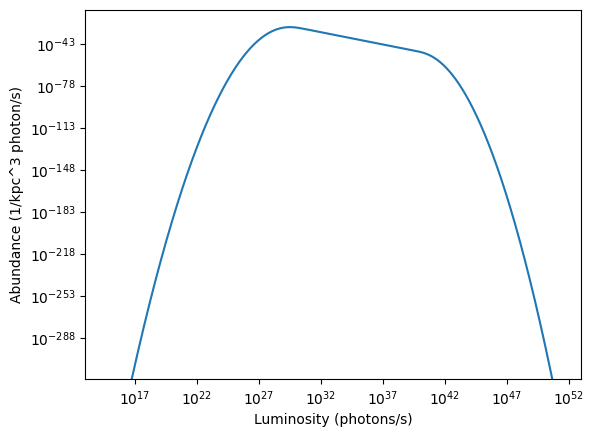

In [81]:
plt.loglog(lums, abundances[1,:])
plt.xlabel('Luminosity (photons/s)')
plt.ylabel('Abundance (1/kpc^3 photon/s)')
plt.xlim(lums[0], lums[-1])
plt.show()